# Projet IAS : Prédire le genre d'un jeu vidéo à partir de sa description / titre
Réalisé par: Clot Arthur, Doncecchi Carlo Elia, Nzongani Ugo, Pham Van Clément, Trinh Duc-Bao et Vu Phuong Nam<br>
Professeur référent: Kim Gerdes<br>
Dataset utilisé: https://www.kaggle.com/nikdavis/steam-store-games

In [90]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.model_selection import train_test_split
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ugo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ugo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# chargement des données
steam = pd.read_csv('archive/steam.csv')
steam_description_data = pd.read_csv('archive/steam_description_data.csv')

# on ne devrait pas avoir besoin de celles-ci
'''
steam_media_data = pd.read_csv('steam_media_data.csv')
steam_requirements_data = pd.read_csv('steam_requirements_data.csv')
steam_support_info = pd.read_csv('steam_support_info.csv')
steamspy_tag_data = pd.read_csv('steamspy_tag_data.csv')
'''

# fonction pour afficher les informations d'un fichier
# si dimensions_type = True, les types des dimensions sont également affichés
def info(file, *dimensions_type):
    dataset_panda = pd.read_csv(file)
    print('*****'+file+'*****\n'+'Nombre de donnée: ', dataset_panda.shape[0],'\nNombre de dimension: ',
          dataset_panda.shape[1],'\n')
    if(dimensions_type):
        print('Types des dimensions:\n', dataset_panda.dtypes)

In [4]:
info('archive/steam.csv', True)
steam

*****archive/steam.csv*****
Nombre de donnée:  27075 
Nombre de dimension:  18 

Types des dimensions:
 appid                 int64
name                 object
release_date         object
english               int64
developer            object
publisher            object
platforms            object
required_age          int64
categories           object
genres               object
steamspy_tags        object
achievements          int64
positive_ratings      int64
negative_ratings      int64
average_playtime      int64
median_playtime       int64
owners               object
price               float64
dtype: object


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


In [5]:
info('archive/steam_description_data.csv', True)
steam_description_data

*****archive/steam_description_data.csv*****
Nombre de donnée:  27334 
Nombre de dimension:  4 

Types des dimensions:
 steam_appid              int64
detailed_description    object
about_the_game          object
short_description       object
dtype: object


,steam_appid,detailed_description,about_the_game,short_description
0,10,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...,Play the world's number 1 online action game. ...
1,20,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...
2,30,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...,Enlist in an intense brand of Axis vs. Allied ...
3,40,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...,Enjoy fast-paced multiplayer gaming with Death...
4,50,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...,Return to the Black Mesa Research Facility as ...
...,...,...,...,...
27329,1065230,"<img src=""https://steamcdn-a.akamaihd.net/stea...","<img src=""https://steamcdn-a.akamaihd.net/stea...",The Room of Pandora is a third-person interact...
27330,1065570,Have you ever been so lonely that no one but y...,Have you ever been so lonely that no one but y...,Cyber Gun is a hardcore first-person shooter w...
27331,1065650,<strong>Super Star Blast </strong>is a space b...,<strong>Super Star Blast </strong>is a space b...,Super Star Blast is a space based game with ch...
27332,1066700,Pursue a snow-white deer through an enchanted ...,Pursue a snow-white deer through an enchanted ...,Pursue a snow-white deer through an enchanted ...


## Preprocessing

In [6]:
# On récupère les valeurs de la colonne steam_appid du fichier steam.csv
steam_id = steam[steam.columns[0]].values
# On récupère toutes les valeurs de toutes les colonnes du fichier steam_description_data.csv
description = steam_description_data[steam_description_data.columns].values
# On récupère les titres des jeux
titles = steam[steam.columns[1]].values

label = steam.columns[9] # la colonne 9 correspond au genre du jeu

features = []
# Le fichier steam_description_data.csv contient plus de jeux que steam.csv, on ne récupère que ceux qu'ils ont en commun

j = 0
for i in range(len(description)):
    if(description[i,0] in steam_id):
        # pour ajouter les titres des jeux
        d = [titles[j]]
        d = np.append(d, description[i, 1:])
        j += 1
        features.append(d)

# On récupère les données
X = np.array(features)
# On récupère les labels
y = steam[label].values

In [7]:
print('X: ',X.shape,'\ny: ',y.shape)

X:  (27075, 4) 
y:  (27075,)


In [8]:
# 1er jeu du fichier steam.csv (en ne prenant que la description)
print('1er jeu du dataset:\n',X[0])
# son label
print('\nLabel: ',y[0])

1er jeu du dataset:
 ['Counter-Strike'
 "Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role."
 "Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role."
 "Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role."]

La

In [9]:
# exemple d'un jeu dont la description est en chinois?
X[24881] 

array(['魔塔2018',
       '《魔塔2018》是一种策略类的RPG游戏。游戏需要动很多脑筋，任何一个轻率的选择都可能导致游戏的失败。<br />\r\n<br />\r\n魔塔制作精美，道具很多，而且有一定难度，对智商是一次艰巨的考验。<br />\r\n<br />\r\n所以如果你喜欢挑战，请一定不要错过!魔塔是一款十分经典的游戏,身为勇士的你必须闯过一层又一层的魔塔 最后到达塔顶 救回你那美丽的公主,魔塔里到处都充满着凶残的怪物，我们必须杀死他们。',
       '《魔塔2018》是一种策略类的RPG游戏。游戏需要动很多脑筋，任何一个轻率的选择都可能导致游戏的失败。<br />\r\n<br />\r\n魔塔制作精美，道具很多，而且有一定难度，对智商是一次艰巨的考验。<br />\r\n<br />\r\n所以如果你喜欢挑战，请一定不要错过!魔塔是一款十分经典的游戏,身为勇士的你必须闯过一层又一层的魔塔 最后到达塔顶 救回你那美丽的公主,魔塔里到处都充满着凶残的怪物，我们必须杀死他们。',
       '这是一款策略类的RPG游戏，通过你的判断与计算和怪物战斗，打败他们救出公主，赢得胜利。'], dtype=object)

### Fonctions

In [10]:
def delete_no_english(X, y):
    steam_langage = steam[steam.columns[3]].values
    cpt = 0
    new_X = []
    new_y = []
    N = X.shape[0]
    for i in range(N):
        # si le jeu n'est pas en anglais
        if(steam_langage[i] == 1):
            new_X.append(X[i])
            new_y.append(y[i])
        else:
            cpt += 1
    print(cpt," jeux ont été enlevés\n")
    return np.array(new_X), np.array(new_y)

def html(s):
    split = s.split('<')
    # on le split à nouveau avec la balise fermante
    s_without_HTML = ""
    # supprimer html
    for i in range(len(split)):
        split[i] = split[i].split('>')
        if(i == 0):
            s_without_HTML += split[i][0]
        elif(len(split[i]) > 1 and split[i][1] != ""):
            if(split[i][1][0] == " "):
                s_without_HTML += split[i][1]
            else:
                s_without_HTML += " " + split[i][1]
    return s_without_HTML

def replace(s, new_values):
    N = len(new_values)
    for i in range(N):
        s = s.replace(new_values[i][0], new_values[i][1])
    return s

def brackets(s):
    brackets = np.array([['(', ')'], ['[', ']'], ['{', '}']])
    N = len(brackets)
    for b in range(N):
        split = s.split(brackets[b,0])
        s_without_brackets = ""
        for k in range(len(split)):
            split[k] = split[k].split(brackets[b,1])
            if(k == 0):
                s_without_brackets += split[k][0]
            elif(len(split[k]) > 1 and split[k][1] != ''):
                if(split[k][1][0] == ' '):
                    s_without_brackets += split[k][1]
                else:
                    s_without_brackets += " " + split[k][1]
        s = s_without_brackets
    return s

def character(s, characters):
    # les éléments de characters seront remplacés par un espace " "
    translation = str.maketrans({i:" " for i in characters})
    # on sépare les mots et on les met dans la liste X_split
    split = s.split(' ')
    s_without_link = ""
    for i in split:
        # on vérifie que chaque mot ne contient pas 'http' ou 'www'
        if(not 'http' in i and not 'www' in i):
            s_without_link += i + " "
        # on supprime les caractères à supprimer
    return s_without_link.translate(translation)

def backslashes(s):
    l = ['\x91','\x92','\x94','\x93','\x97','\x96','\x80','\x99','\x98','\xad','\x7f','\u200b','\u200f','\ufeff','/','\n',
        '\t','\r']
    for i in l:
        s = s.replace(i, " ")
    return s

def numbers_lowerCase(s):
    s_without_numbers = ""
    N = len(s)
    for i in range(N):
        if(s[i].isdigit()):
            s_without_numbers += " "
        else:
            s_without_numbers += s[i]
    return s_without_numbers.lower()

def stopword(s, stopwords):
    modif = False
    split = s.split(" ")
    s_without_stopwords = ""
    for i in split:
        if(i not in stopwords):
            s_without_stopwords += i + " "
    split = s_without_stopwords.split(" ")
    s_without_one_letter_words = ""
    N = len(split)
    for i in range(N):
        if(len(split[i]) > 1 and split[i] != " "):
            modif = True
            if(i == N - 1): # dernier élement donc on ne met pas d'espace
                s_without_one_letter_words += split[i]
            else:
                s_without_one_letter_words += split[i] + " "
    N = len(s_without_one_letter_words)
    # on vérifie que le dernier caractère n'est pas un espace
    if(modif and s_without_one_letter_words[N-1] == " "):
        s_without_one_letter_words = s_without_one_letter_words[:N-1]
    return s_without_one_letter_words

def clear_string(s, replacement, characters, stopwords):
    return stopword(numbers_lowerCase(backslashes(character(brackets(replace(html(s), replacement)), characters))), stopwords)

def clear_all_data(X, replacement, characters, stopwords):
    N = X.shape[0]
    D = X.shape[1]
    for i in range(N):
        for j in range(D):
            X[i,j] = clear_string(X[i,j], replacement, characters, stopwords)
        
def delete_no_ascii(X, y):
    new_X = []
    new_y = []
    cpt=0
    for i in range(len(X)):
        # indique si il y a des caractères non ascii
        no_ascii = True
        for e in X[i]:
            # si le caractères n'est pas ascii
            if(re.sub('[ -~]', '', e) != ""):
                no_ascii = False
        if(no_ascii):
            new_X.append(X[i])
            new_y.append(y[i])
        else:
            cpt += 1
    print(cpt," jeux ont été enlevés\n")
    return np.array(new_X), np.array(new_y)
                        
def lemmatize(X, tokenize=False):
    N = X.shape[0]
    D = X.shape[1]
    new_X = np.empty((N, D), object)
    lemmatizer = WordNetLemmatizer()
    for i in range(N):
        for j in range(D):
            X_split = X[i,j].split(" ")  
            X_lemmatized = ""
            for k in range(len(X_split)):
                if(k == len(X_split) - 1):
                    X_lemmatized += lemmatizer.lemmatize(X_split[k], wordnet.VERB)
                else:
                    X_lemmatized += lemmatizer.lemmatize(X_split[k], wordnet.VERB) + " "
            if(tokenize):
                new_X[i,j] = X_lemmatized.split(" ")
            else:
                new_X[i,j] = X_lemmatized
    return new_X

# renvoi la liste des labels contenus dans y
def get_labels(y):
    labels = []
    N = y.shape[0]
    for i in range(N):
        y_split = y[i].split(" ")
        for j in y_split:
            if(j not in labels and j != " "):
                labels.append(j)
    return np.array(labels)

def rename_labels(y):
    N = y.shape[0]
    characters = ["&", ";"]
    translation = str.maketrans({i:" " for i in characters})
    for i in range(N):
        y[i] = y[i].translate(translation).lower()
        y[i] = y[i].replace("free to play", "free")
        y[i] = y[i].replace("animation   modeling", "animation")
        y[i] = y[i].replace("video production", "video")
        y[i] = y[i].replace("massively multiplayer", "multiplayer")
        y[i] = y[i].replace("early access", "early")
        y[i] = y[i].replace("design   illustration", "design")
        y[i] = y[i].replace("web publishing", "web")
        y[i] = y[i].replace("software training", "software")
        y[i] = y[i].replace("sexual content", "sexual")
        y[i] = y[i].replace("audio production", "audio")
        y[i] = y[i].replace("game development", "development")
        y[i] = y[i].replace("photo editing", "photo")
        #y[i] = y[i].replace("rpg", "role")
        
def keep_first_label_only(y):
    N = y.shape[0]
    new_y = []
    for i in range(N):
        y_split = y[i].split(" ")
        new_y.append(y_split[0])
    return np.array(new_y)

def prepro(X, y, replacement, character, stopwords):
    print("Preprocessing:\n\nSuppression des jeux non anglais: ")
    X, y = delete_no_english(X, y)
    print("✔\n")
    print("Nettoyage du texte: ")
    clear_all_data(X, replacement, character, stopwords)
    print("✔\n")
    print("Suppression des caractères non ASCII restants: ")
    X, y = delete_no_ascii(X, y)
    print("✔\n")
    print("Renommage des labels: ")
    rename_labels(y)
    print("✔\n")
    return X, y

# sélectionne aléatoirement nb données dans le dataset
def select_data(X, y, nb):
    new_X = np.empty((nb, X.shape[1]), object)
    new_y = np.array([])
    N = X.shape[0]
    index = np.arange(N)
    for i in range(nb):
        r = random.randint(0, len(index)-1)
        new_X[i] = X[r]
        new_y = np.append(new_y, y[r])
        index = np.delete(index, r)
    return new_X, new_y

In [11]:
replacement = np.array([["ê","e"],["é","e"],["è","e"],["ë","e"],["à","a"],["ä","a"],["ä","a"],["å","a"],["ł","l"],
                        ["ü","u"],["û","u"],["ö","o"],["ô","o"],["Ö","o"],["ò","o"],["í","i"],["ï","i"],["î","i"],["Ã","a"],
                        ["Ä","a"],["ž","z"],["ì","i"],["Ñ","n"],["ñ","n"],["á","a"],["ø","o"],["Á","a"],["á","a"],
                        ["Ü","u"],["ō","o"],["ú","u"],["ã","a"],["É","e"],["×","x"],["Ó","o"],["С","c"],["、",","],
                        ["ɑ","a"],["ñ","n"],["ũ","u"],["ó","o"],["â","a"],["Û","u"],["ū","u"],["õ","o"],["，",","],
                        ["ń","n"],["х","x"],["А","a"],["с","c"],["Ś","s"],["Т","t"],["a","a"]])

character_to_delete = np.array(['•','€','™','*','-','–','¢','˜','«','»','®','+','µ','·','¹','¬','º','½','±','©','§','ª','ƒ',
                              '¿','Ð','¸','¼','Ø','¨','æ','‡','“','”','ç','¥','œ','´','#','—','‘','…', '²', '●', '³', '・',
                                '∞','√','∼','✢','※','◾','■','★','➠','―','„','✓','▶','◆','ລ','▪','♪','♞','♥','Ω','α',
                                'Λ','♫','「','」','：','◕','_','つ','༽','༼','⚠','✔','』','『','►','☆','℗','✗','✪','†','《',
                                '》','一','。','～','‐','″','↑','@','◉','♂','♀','＊','【','】','＊','＜','＞','→','↓','←',
                                '①','②','③','▽','△','○','Ⅶ','□','（','）','%','Ⅱ','~','°','&',',', '!', '?', ':', '.', ';',
                                '"',"'",'′','’','＋','=','|','~','^', '@','$'])

stopwords = np.loadtxt("stopwords.txt",str)

In [12]:
# préprocessing (5m)
X, y = prepro(X, y, replacement, character_to_delete, stopwords)

Preprocessing: environ 3m

Suppression des jeux non anglais: 
511  jeux ont été enlevés

✔

Nettoyage du texte: 
✔

Suppression des caractères non ASCII restants: 
976  jeux ont été enlevés

✔

Renommage des labels: 
✔



In [13]:
# on choisit le nombre de données qu'on veut utiliser
nb_data = 20000
X, y = select_data(X, y, nb_data)

In [14]:
print('X: ',X.shape,'\ny: ',y.shape)

X:  (20000, 4) 
y:  (20000,)


In [15]:
# premier jeu du dataset
X[0], y[0]

(array(['seasons fall',
        'twitch dev session game seasons fall platform puzzler game dive captivating universe explore land governed magic nature wild fox perilous journey aided ability change seasons manipulating gorgeous world backed enchanting live string quartet power nature paws make journey mysterious world full strange flora fauna seasons drastic change environment change world open paths winter freeze waterfalls rain spring raise water levels summer plants grow extend world seasons fall overflowing secrets uncover truth feels weird forest order complete quest mystical abilities meet guardians gain powers guardians seasons gigantic totemic spirits protectors mysterious sacred ritual bear winter crane autumn eel spring cicada summer allies enemies discover world brought life stunning hand painted graphics original music performed string quartet visit enchanted vistas sceneries music mood atmosphere change seamlessly seasons',
        'seasons fall platform puzzler game div

In [16]:
# Lemmatisation
# Nous nous sommes inspirés de ce code pour la lemmatisation:
# https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python

# Pour que les descriptions soient des listes de mots
X_tokenized = lemmatize(X, tokenize=True)

# Pour laisser les descriptions en chaînes de caractères
X_not_tokenized = lemmatize(X)

In [17]:
# Voilà ce qu'on obtient sur le 1er jeu avec X_tokenized
print('X_tokenized[0]:\n', X_tokenized[0])

X_tokenized[0]:
 [list(['season', 'fall'])
 list(['twitch', 'dev', 'session', 'game', 'season', 'fall', 'platform', 'puzzler', 'game', 'dive', 'captivate', 'universe', 'explore', 'land', 'govern', 'magic', 'nature', 'wild', 'fox', 'perilous', 'journey', 'aid', 'ability', 'change', 'season', 'manipulate', 'gorgeous', 'world', 'back', 'enchant', 'live', 'string', 'quartet', 'power', 'nature', 'paw', 'make', 'journey', 'mysterious', 'world', 'full', 'strange', 'flora', 'fauna', 'season', 'drastic', 'change', 'environment', 'change', 'world', 'open', 'paths', 'winter', 'freeze', 'waterfalls', 'rain', 'spring', 'raise', 'water', 'level', 'summer', 'plant', 'grow', 'extend', 'world', 'season', 'fall', 'overflow', 'secrets', 'uncover', 'truth', 'feel', 'weird', 'forest', 'order', 'complete', 'quest', 'mystical', 'abilities', 'meet', 'guardians', 'gain', 'power', 'guardians', 'season', 'gigantic', 'totemic', 'spirit', 'protectors', 'mysterious', 'sacred', 'ritual', 'bear', 'winter', 'crane', '

In [18]:
# Voilà ce qu'on obtient sur le 1er jeu avec X_not_tokenized
print('\nX_not_tokenized[0]:\n', X_not_tokenized[0])


X_not_tokenized[0]:
 ['season fall'
 'twitch dev session game season fall platform puzzler game dive captivate universe explore land govern magic nature wild fox perilous journey aid ability change season manipulate gorgeous world back enchant live string quartet power nature paw make journey mysterious world full strange flora fauna season drastic change environment change world open paths winter freeze waterfalls rain spring raise water level summer plant grow extend world season fall overflow secrets uncover truth feel weird forest order complete quest mystical abilities meet guardians gain power guardians season gigantic totemic spirit protectors mysterious sacred ritual bear winter crane autumn eel spring cicada summer ally enemies discover world bring life stun hand paint graphics original music perform string quartet visit enchant vistas sceneries music mood atmosphere change seamlessly season'
 'season fall platform puzzler game dive captivate universe explore land govern magi

In [19]:
# Labels
print('Tous les labels: \n', get_labels(y))
print('Il y a ', len(get_labels(y)), ' labels uniques\n')

# Pour ne garder que le premier genre d'un jeu
y_first = keep_first_label_only(y)
print("Tous les labels: \n", get_labels(y_first))
print('Il y a ', len(get_labels(y_first)), ' labels uniques si on ne prends que les 1er de chaque jeu\n')

Tous les labels: 
 ['adventure' 'indie' 'action' 'casual' 'sports' 'free' 'multiplayer'
 'simulation' 'photo' 'utilities' 'video' 'early' 'strategy' 'rpg'
 'violent' 'gore' 'racing' 'education' 'sexual' 'animation' 'design'
 'audio' 'software' 'nudity' 'web' 'development' 'accounting']
Il y a  27  labels uniques

Tous les labels: 
 ['adventure' 'action' 'casual' 'photo' 'indie' 'simulation' 'sports'
 'violent' 'gore' 'rpg' 'sexual' 'strategy' 'free' 'racing' 'animation'
 'audio' 'nudity' 'utilities' 'multiplayer' 'early' 'education' 'design'
 'web' 'video' 'accounting']
Il y a  25  labels uniques si on ne prends que les 1er de chaque jeu



## Debut visualisation

In [20]:
def get_labels_list(y):
    labels = []
    N = y.shape[0]
    for i in range(N):
        y_split = y[i].split(" ")
        for j in y_split:
            if(j != " "):
                labels.append(j)
    return np.array(labels)

print(y)
print(get_labels_list(y))

['adventure indie' 'action casual indie' 'adventure indie' ... 'racing'
 'action adventure indie' 'rpg']
['adventure' 'indie' 'action' ... 'adventure' 'indie' 'rpg']


In [21]:
#fonction qui prend en param:
#liste y du dataset (taille=76k)
#et liste des 26 genres qui existent sans duplication (taille=26)
def genre_count(y, genres):
    list_genre_count = []
    for genre in genres:
        count=0
        for genre2 in y:
            if genre==genre2:
                count+=1
        list_genre_count.append(count)
    return list_genre_count

genreLabels = get_labels(y_first)
list_genre_count=genre_count(get_labels_list(y), genreLabels)
print(list_genre_count)

[7169, 9133, 6191, 11, 13530, 3584, 934, 468, 284, 3214, 136, 4162, 1115, 809, 56, 18, 147, 103, 523, 1728, 41, 58, 23, 33, 2]


Text(0.5, 1.0, 'Nombre de jeux par genre')

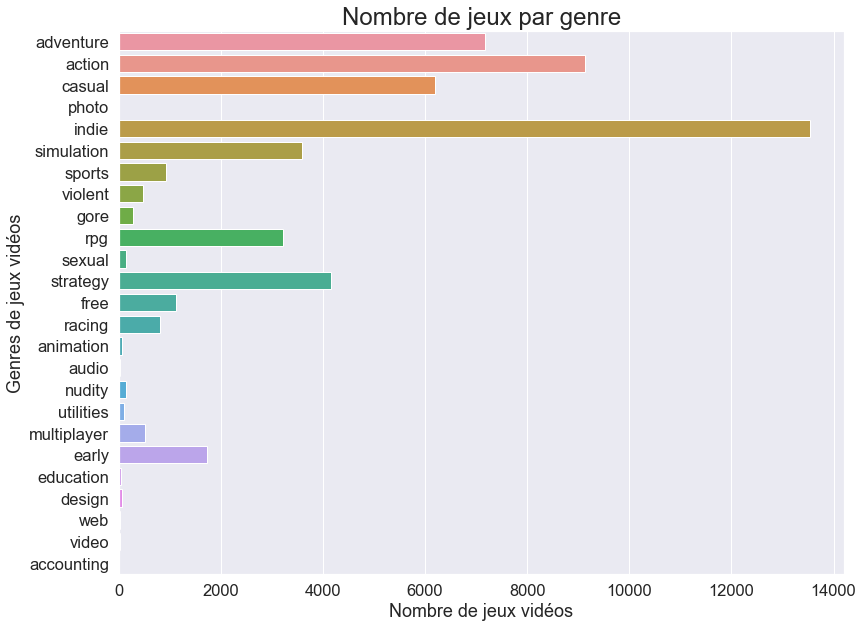

In [22]:
plt.figure(figsize=(13, 10))
# Bar chart
sns.set(font_scale=1.5) #taille du texte
sns.barplot(x=list_genre_count, y=genreLabels)
plt.xlabel("Nombre de jeux vidéos")
plt.ylabel("Genres de jeux vidéos")
sns.set(font_scale=2)
plt.title("Nombre de jeux par genre")

In [23]:
def count_genre_in_description(X, y, tokenized=False):
    N = X.shape[0]
    D = X.shape[1]
    genres = y
    count=0
    for i in range(N):
        for j in range(D):
            if(tokenized):
                for k in X[i,j]:
                    if(k in genres[i]):
                        count+=1
                        break #on compte seulement 1 fois si un jeu a son genre en description
                              #peu importe si la description contient le genre une ou plusieurs fois
            else:
                X_split = X[i,j].split(" ")
                for k in X_split:
                    if(k in genres[i]):
                        count+=1
                        break #on compte seulement 1 fois si un jeu a son genre en description
                              #peu importe si la description contient le genre une ou plusieurs fois
    return count

In [24]:
# tokenized est à True car on utilise X_tokenized
nb_jeu_avec_genre_en_description = count_genre_in_description(X_tokenized, y_first, tokenized=True)
nb_jeu_total = len(y_first)

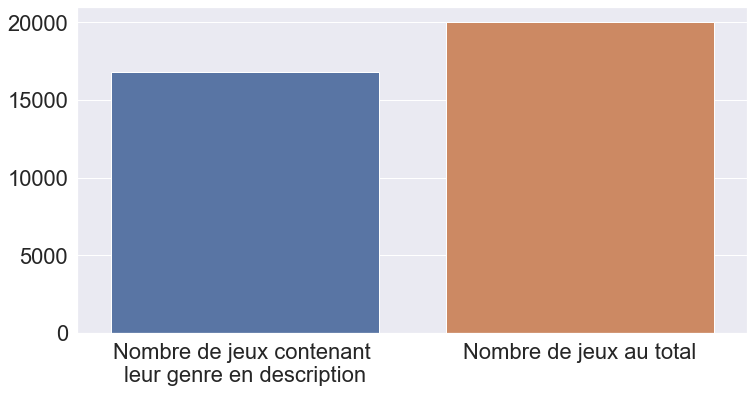

In [25]:
plt.figure(figsize=(12, 6))

x_bar = ['Nombre de jeux contenant \nleur genre en description', 'Nombre de jeux au total']
y_bar = [nb_jeu_avec_genre_en_description, nb_jeu_total]

sns.barplot(x_bar, y_bar)

## Fin visualisation

## Preprocessing supplémentaire pour utiliser la méthode bag of words

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

In [28]:
# on a choisi les genres les plus populaires
genres_choice = ['action', 'indie', 'strategy', 'rpg', 'casual', 'simulation', 'adventure']

# on fusionne les genres peu fréquents en un seule genre nommé "other"
for i in range(len(y_first)):
    if(y_first[i] not in genres_choice):
        y_first[i] = "other"

In [29]:
# enlève le genre dans la description
def remove_genres_X_list(X, y):
    N = X.shape[0]
    D = X.shape[1]
    genres = get_labels(y)
    for i in range(N):
        for j in range(D):
            X_split = X[i,j].split(" ")
            for k in X_split:
                if(k in genres):
                    X[i,j] = X[i,j].replace(k, "")

In [30]:
# on enleve le genre du jeu de la description du jeu s'il est present
remove_genres_X_list(X_not_tokenized, y_first)

Maintenant que tout le préprocessing est terminé, on va créer les 3 jeux de données suivants:
    - X_description qui contient les 3 descriptions concaténées de chaque jeu
    - X_title qui contient le titre de chaque jeu
    - X_title_description qui contient le titre concaténé aux descriptions de chaque jeu

In [32]:
N = X_not_tokenized.shape[0]

X_title = []
X_description = []
X_title_description = []

for i in range(N):
    # que les titres
    X_title.append(X_not_tokenized[i][0])
    # que les descriptions
    features_description = X_not_tokenized[i][1] + " " + X_not_tokenized[i][2] + " " + X_not_tokenized[i][3]
    X_description.append(features_description)
    # titres + descriptions
    features_title_description = X_not_tokenized[i][0] + " " + features_description
    X_title_description.append(features_title_description)
    
X_title = np.array(X_title)
X_description = np.array(X_description)
X_title_description = np.array(X_title_description)

In [33]:
X_title

array(['season fall', 'castle', 'sandra woo curse ', ..., 'burn cars',
       'stick em paper ', 'sydney world'], dtype='<U70')

In [34]:
X_description

array(['twitch dev session game season fall platform puzzler game dive captivate universe explore land govern magic nature wild fox perilous journey aid ability change season manipulate gorgeous world back enchant live string quartet power nature paw make journey mysterious world full strange flora fauna season drastic change environment change world open paths winter freeze waterfalls rain spring raise water level summer plant grow extend world season fall overflow secrets uncover truth feel weird forest order complete quest mystical abilities meet guardians gain power guardians season gigantic totemic spirit protectors mysterious sacred ritual bear winter crane autumn eel spring cicada summer ally enemies discover world bring life stun hand paint graphics original music perform string quartet visit enchant vistas sceneries music mood atmosphere change seamlessly season season fall platform puzzler game dive captivate universe explore land govern magic nature wild fox perilous journey

In [35]:
X_title_description

array(['season fall twitch dev session game season fall platform puzzler game dive captivate universe explore land govern magic nature wild fox perilous journey aid ability change season manipulate gorgeous world back enchant live string quartet power nature paw make journey mysterious world full strange flora fauna season drastic change environment change world open paths winter freeze waterfalls rain spring raise water level summer plant grow extend world season fall overflow secrets uncover truth feel weird forest order complete quest mystical abilities meet guardians gain power guardians season gigantic totemic spirit protectors mysterious sacred ritual bear winter crane autumn eel spring cicada summer ally enemies discover world bring life stun hand paint graphics original music perform string quartet visit enchant vistas sceneries music mood atmosphere change seamlessly season season fall platform puzzler game dive captivate universe explore land govern magic nature wild fox peri

### Fin du preprocessing

# Model
Méthode Bag of words

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [52]:
# pourcentage du dataset utilisé pour l'ensemble de test
test_ratio = 0.3
seed = 7

# que les descriptions
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_description, y_first, test_size=test_ratio, train_size=1-test_ratio,random_state=seed)

# que les titres
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_title, y_first, test_size=test_ratio, train_size=1-test_ratio,random_state=seed)

# titres et descriptions
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_title_description, y_first, test_size=test_ratio, train_size=1-test_ratio,random_state=seed)


# Nous nous sommes inspiré de ce notebook pour l'utilisation de CountVectorizer:
# https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/Document%20classification%20with%20word%20embeddings%20tutorial.ipynb

# entrainement, on va compter le nombre d'occurences des mots avec CountVectorizer pour les mettre dans une matrice
count_vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None)

On test les 3 modèles suivants:
    - KNeighborsClassifier
    - DecisionTreeClassifier
    - LogisticRegression

### KNeighborsClassifier et DecisionTreeClassifier

In [70]:
def print_perf(X_train, X_test, y_train, y_test, vectorizer, model, titre1, titre2, titre3):
    train_data_features = vectorizer.fit_transform(X_train)
    # entraînement des modèles
    model.fit(train_data_features, y_train)

    data_features_train = vectorizer.transform(X_train)
    data_features_test = vectorizer.transform(X_test)

    # prédictions sur l'ensemble d'entraînement
    predictions_train = model.predict(data_features_train)

    # prédictions sur l'ensemble de test
    predictions_test = model.predict(data_features_test)

    print(titre1)
    print(titre2, accuracy_score(y_train, predictions_train))
    print(titre3, accuracy_score(y_test, predictions_test))

In [72]:
print('----- KNeighborsClassifier -----')
print_perf(X_train1, X_test1, y_train1, y_test1,count_vectorizer, KNeighborsClassifier(),'Seulement avec les descriptions',
          'Score sur le train set: ','Score sur le test set: ')
print_perf(X_train2, X_test2, y_train2, y_test2,count_vectorizer, KNeighborsClassifier(),'\nSeulement avec les titres',
          'Score sur le train set: ','Score sur le test set: ')
print_perf(X_train3, X_test3, y_train3, y_test3,count_vectorizer, KNeighborsClassifier(),'\nAvec les titres et descriptions',
          'Score sur le train set: ','Score sur le test set: ')

----- KNeighborsClassifier -----
Seulement avec les descriptions
Score sur le train set:  0.7291428571428571
Score sur le test set:  0.5371666666666667

Seulement avec les titres
Score sur le train set:  0.7040714285714286
Score sur le test set:  0.5443333333333333

Avec les titres et descriptions
Score sur le train set:  0.7342857142857143
Score sur le test set:  0.5305


In [73]:
print('----- DecisionTreeClassifier -----')
print_perf(X_train1, X_test1, y_train1, y_test1,count_vectorizer, DecisionTreeClassifier(),'Seulement avec les descriptions',
          'Score sur le train set: ','Score sur le test set: ')
print_perf(X_train2, X_test2, y_train2, y_test2,count_vectorizer, DecisionTreeClassifier(),'\nSeulement avec les titres',
          'Score sur le train set: ','Score sur le test set: ')
print_perf(X_train3, X_test3, y_train3, y_test3,count_vectorizer, DecisionTreeClassifier(),'\nAvec les titres et descriptions',
          'Score sur le train set: ','Score sur le test set: ')

----- DecisionTreeClassifier -----
Seulement avec les descriptions
Score sur le train set:  1.0
Score sur le test set:  0.7385

Seulement avec les titres
Score sur le train set:  0.9839285714285714
Score sur le test set:  0.7156666666666667

Avec les titres et descriptions
Score sur le train set:  1.0
Score sur le test set:  0.7413333333333333


Géneralement les meilleurs résultats ont l'air d'êtres obtenus avec X_title_description, c'est le jeu de données contenant les titres et les descriptions. Pour le moment le DecisionTreeClassifier semble être meilleur que le KNeighborsClassifier. Nous allons maintenant modifier l'hyper-paramètre **n_neighbors** pour le KNeighborsClassifier et les hyper-paramètres **criterion** et **splitter** pour le DecisionTreeClassifier. 

In [74]:
# KNeighborsClassifier sur X_title_description (X_train3)
n_neighbors_list = [5, 6, 7, 8, 9, 10]

for i in n_neighbors_list:
    print_perf(X_train3, X_test3, y_train3, y_test3,count_vectorizer, KNeighborsClassifier(n_neighbors=i),
               '\nn_neighbors= '+str(i), 'Score sur le train set: ', 'Score sur le test set: ')


n_neighbors= 5
Score sur le train set:  0.7342857142857143
Score sur le test set:  0.5305

n_neighbors= 6
Score sur le train set:  0.7122857142857143
Score sur le test set:  0.5206666666666667

n_neighbors= 7
Score sur le train set:  0.6836428571428571
Score sur le test set:  0.503

n_neighbors= 8
Score sur le train set:  0.6632142857142858
Score sur le test set:  0.4876666666666667

n_neighbors= 9
Score sur le train set:  0.6397142857142857
Score sur le test set:  0.4826666666666667

n_neighbors= 10
Score sur le train set:  0.6203571428571428
Score sur le test set:  0.47533333333333333


In [75]:
# DecisionTreeClassifier sur X_title_description (X_train3)
criterion_list = ['gini', 'entropy']
splitter_list = ['best', 'random']

for i in criterion_list:
    for j in splitter_list:
        print_perf(X_train3, X_test3, y_train3, y_test3,count_vectorizer, DecisionTreeClassifier(criterion=i, splitter=j),
               '\ncriterion= '+i+' , splitter= '+j, 'Score sur le train set: ', 'Score sur le test set: ')


criterion= gini , splitter= best
Score sur le train set:  1.0
Score sur le test set:  0.7411666666666666

criterion= gini , splitter= random
Score sur le train set:  1.0
Score sur le test set:  0.736

criterion= entropy , splitter= best
Score sur le train set:  1.0
Score sur le test set:  0.7406666666666667

criterion= entropy , splitter= random
Score sur le train set:  1.0
Score sur le test set:  0.737


Le DecisionTreeClassifier est le meilleur des deux et ses meilleurs hyper-paramètres semblent être
criterion= gini et splitter = best.
On test maintenant le LogisticRegression
### LogisticRegression

In [77]:
def plot_train_test(train_score, test_score, iteration, titre):
    plt.plot(iteration,train_score,color='red', label='Train set')
    plt.plot(iteration,test_score,color='blue', label='Test set')
    plt.title('Erreur d\'entraînement et de test '+titre, size=15)
    plt.xlabel('Iteration', size=15)
    plt.ylabel('Score', size=15)
    plt.legend()
    plt.show()
    
# on compare l'erreur entre le training set et le test
def error_train_test_set(X_train, y_train, X_test, y_test):
    test_score = []
    train_score = []
    iteration = []

    train_data_features = count_vectorizer.fit_transform(X_train)

    for i in range(5, 100+5, 5):
        iteration.append(i)
        model = LogisticRegression(max_iter = i)
        model.fit(train_data_features, y_train)
        data_features_train = count_vectorizer.transform(X_train)
        predictions_train = model.predict(data_features_train)
        data_features_test = count_vectorizer.transform(X_test)
        predictions_test = model.predict(data_features_test)
        train_score.append(accuracy_score(y_train, predictions_train))
        test_score.append(accuracy_score(y_test, predictions_test))
    return train_score, test_score, iteration

In [78]:
# execution longue

# seulement avec les descriptions
train_score1, test_score1, iteration1 = error_train_test_set(X_train1, y_train1, X_test1, y_test1)

# seulement avec les titres
train_score2, test_score2, iteration2 = error_train_test_set(X_train2, y_train2, X_test2, y_test2)

# avec les deux
train_score3, test_score3, iteration3 = error_train_test_set(X_train3, y_train3, X_test3, y_test3)

C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

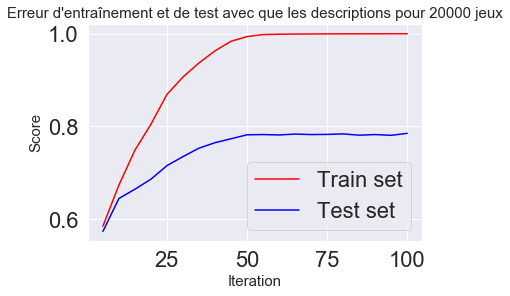

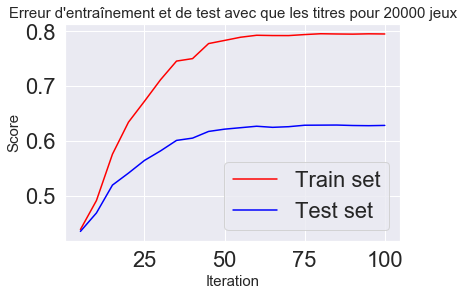

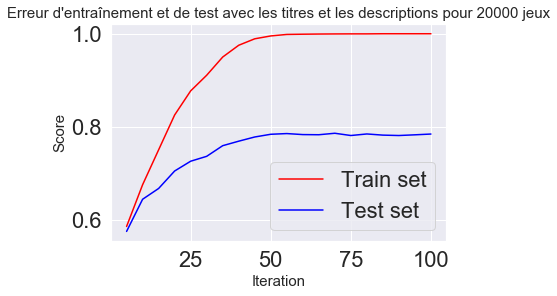

In [79]:
# affichage de l'erreur d'entraînement et de l'erreur de test pour le modèle LogisticRegression
plot_train_test(train_score1, test_score1, iteration1, 'avec que les descriptions pour 20000 jeux')
plot_train_test(train_score2, test_score2, iteration2, 'avec que les titres pour 20000 jeux')
plot_train_test(train_score3, test_score3, iteration3, 'avec les titres et les descriptions pour 20000 jeux')

Le jeu de données ne contenant que les titres est le moins bon, les 2 entres sembles équivalents en terme de résultats pour le modèle, comme pour les 2 autres modèles on choisit d'utiliser le jeu de données avec les titres et les descriptions

In [80]:
# on affiche les erreurs sur le train et le test set pour différentes tailles du dataset (execution assez longue)
train_score4, test_score4, iteration4 = error_train_test_set(X_train3[:10000], y_train3[:10000], X_test3[:10000], y_test3[:10000])
train_score5, test_score5, iteration5 = error_train_test_set(X_train3[:1000], y_train3[:1000], X_test3[:1000], y_test3[:1000])
train_score6, test_score6, iteration6 = error_train_test_set(X_train3[:100], y_train3[:100], X_test3[:100], y_test3[:100])

C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

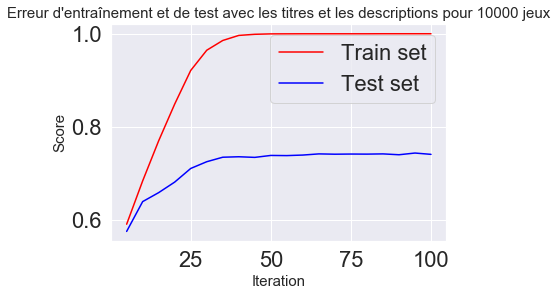

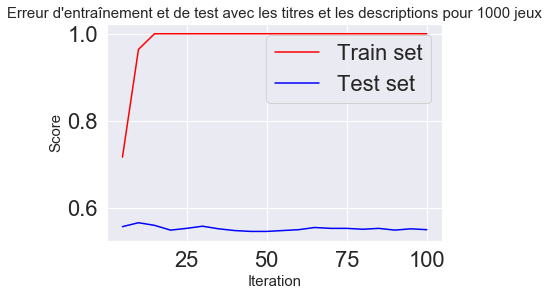

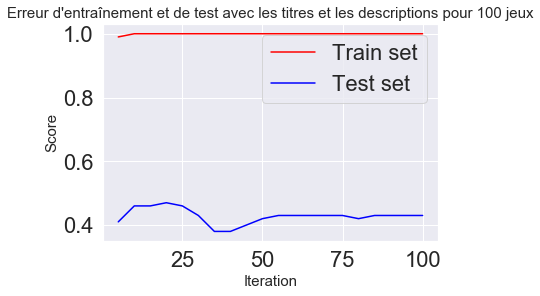

In [81]:
plot_train_test(train_score4, test_score4, iteration4, 'avec les titres et les descriptions pour 10000 jeux')
plot_train_test(train_score5, test_score5, iteration5, 'avec les titres et les descriptions pour 1000 jeux')
plot_train_test(train_score6, test_score6, iteration6, 'avec les titres et les descriptions pour 100 jeux')

Le meilleur modèle des 3 est le LogisticRegression car c'est avec lui qu'on obtient les meilleurs scores sur les ensembles d'entraînements et de tests. On voit qu'après environ 70 itérations le score stagne, on va donc fixer le nombre d'itération maximal à 70.

### On créer notre modèle final

In [82]:
# on prends le jeu de donnée avec les titres et les descriptions comme jeu de données final
# on utilise le modèle de régression logistique
train_data_features = count_vectorizer.fit_transform(X_train3)
model = LogisticRegression(max_iter=70)

# entraînement du modèle
model.fit(train_data_features, y_train3)

data_features_train = count_vectorizer.transform(X_train3)
data_features_test = count_vectorizer.transform(X_test3)

# prédictions du modèles sur le train set
predictions_train = model.predict(data_features_train)
# prédictions du modèles sur le test set
predictions_test = model.predict(data_features_test)

# Affichage des scores obtenus
print('Score du model sur le train set: %s' % accuracy_score(y_train3, predictions_train))
print('Score du model sur le test set: %s' % accuracy_score(y_test3, predictions_test))

C:\Users\Ugo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Score du model sur le train set: 0.9995
Score du model sur le test set: 0.7863333333333333


In [83]:
count_vectorizer.get_feature_names()[90:100] # pour voir quelques exemples de mots dans les descriptions

['abrams',
 'abrasive',
 'abraxas',
 'abreast',
 'abridge',
 'abrix',
 'abroad',
 'abrupt',
 'abruptly',
 'abs']

In [88]:
print("La taille du vocabulaire est " + str(train_data_features3.shape[1]))

La taille du vocabulaire est 42442


In [89]:
cm = confusion_matrix(y_test3, predictions_test)
print('Matrice de confusion non normalisée\n %s' % cm)

Matrice de confusion non normalisée
 [[2300  120   58   75   39    5    6    6]
 [ 127  885   50   37   17    5    3    0]
 [  94   78  554   38   13    3    7    2]
 [  85   47   46  386   15    3   18    7]
 [  85   43   21   19  252    0    5    1]
 [   8   11    3    3    1   73    0    0]
 [   7    6    8    9    3    0  142   10]
 [  15    3    3    9    1    3    1  126]]


Text(0.5, 1.0, 'Matrice de confusion (normalisée)')

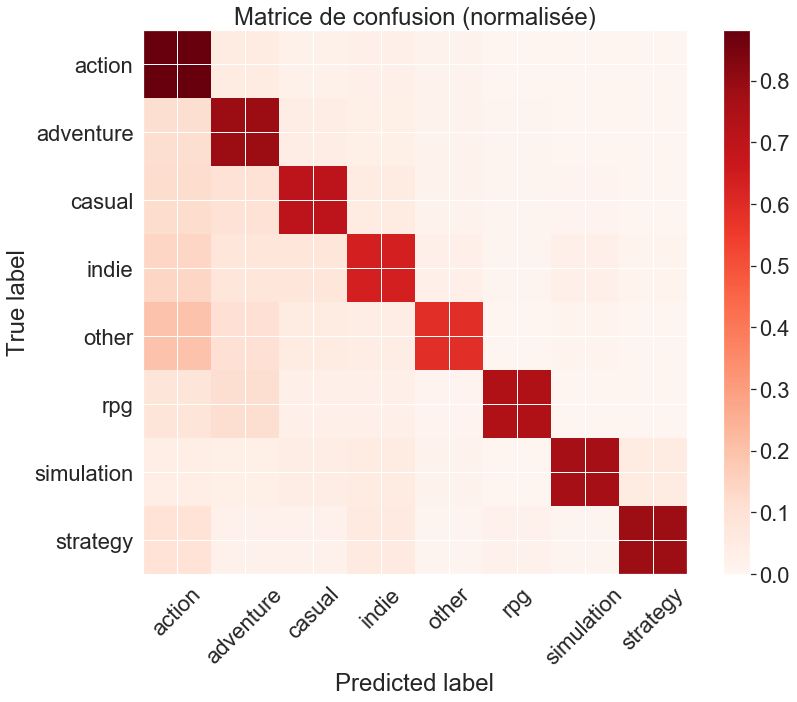

In [86]:
fig, ax = plt.subplots(figsize=(13, 10))
plot_confusion_matrix(model, data_features_test, y_test3, include_values=False, xticks_rotation=45, cmap=plt.cm.Reds, normalize='true', ax=ax)
plt.title("Matrice de confusion (normalisée)")